# Investigate VAE decision boundaries

## Structure
##### 1. Define VAE architecture
##### 2. Define functions to vary the proportion of training examples (0s vs. 7s) and loss penalties for mis-classifying 0s vs. 7s
##### 3. Train ordinary VAE (equal number of training examples for 0s and 7s and equal loss penalty for 0s and 7s) and investigate its decision boundary
##### 4. Find the decision boundary of an ordinary VAE
##### 5. Use points on the decision boundary to generate 1,000 digit samples (decode)
##### 6. Train 4 VAE models on asymmetric loss: 10x, 50x, 100x, 1000x
##### 7. Feed the 1000 decision-boundary points from the latent space of the ordinary VAE to the 3 asymmetric VAEs and see where they are located on the latent space

### 1. Define VAE architecture

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [28]:
## Common VAE architecture
#MODEL
#Input image --> Hidden dim --> mean, std --> Parametrization trick --> Decoder --> Output image
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim = 200, z_dim = 20):
        super().__init__()

        #take image: convert to hidden dim
        self.img_2hid = nn.Linear(input_dim, hidden_dim)
        #encoder: encode to mean and std
        self.hid_2mu = nn.Linear(hidden_dim, z_dim)
        self.hid_2sigma = nn.Linear(hidden_dim, z_dim)

        #decoder: decode to image
        #first: flatten: z to hidden dim
        self.z_2hid = nn.Linear(z_dim, hidden_dim)
        #second, hidden dim to image
        self.hid_2img = nn.Linear(hidden_dim, input_dim)

        #define relu
        self.relu = nn.ReLU()

        
    def encode(self, x):
        #q_phi(z|x)
        
        #flatten
        h = self.relu(self.img_2hid(x))
        
        #get mean, var
        mu = self.hid_2mu(h)
        
        #get variance (and ensure it's positive with softplus)
        #sigma = self.hid_2sigma(h)
        sigma = F.softplus(self.hid_2sigma(h))
    
        return mu, sigma


    def decode(self, z):
        #p_theta(x|z)
        
        #flatten the latent
        h = self.relu(self.z_2hid(z))
        
        #decode
        decoded = self.hid_2img(h)

        return torch.sigmoid(decoded)

    def forward(self, x):
        #encode
        mu, sigma = self.encode(x)

        #before decoding: use reparametrization trick
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        #decode
        x_reconstructed = self.decode(z_reparametrized)

        #need mu, sigma for loss
        return x_reconstructed, mu, sigma

## 2. Define functions to vary the proportion of training examples (0s vs. 7s) and loss penalties for mis-classifying 0s vs. 7s

In [29]:
## 1. Vary the proportion of training examples
def create_custom_dataset(full_dataset, digit_proportions):
    # digit_proportions: dictionary with digits as keys and their desired proportions as values, e.g., {0: 0.7, 7: 0.3}
    
    # Filter datasets for each digit
    digit_datasets = {}
    for digit, proportion in digit_proportions.items():
        indices = (full_dataset.targets == digit)
        digit_datasets[digit] = Subset(full_dataset, np.where(indices)[0])

    # Calculate the maximum allowable total size
    min_size_ratio = min([len(digit_datasets[digit]) / proportion for digit, proportion in digit_proportions.items()])
    total_size = int(min_size_ratio)
    
    # Calculate the number of samples for each digit based on the adjusted total size
    digit_sizes = {digit: int(proportion * total_size) for digit, proportion in digit_proportions.items()}
    
    # Adjust sizes to not exceed available images for each digit
    for digit, size in digit_sizes.items():
        available_images = len(digit_datasets[digit])
        if size > available_images:
            print(f"Requested size for digit {digit} exceeds available images. Adjusting from {size} to {available_images}.")
            digit_sizes[digit] = available_images
    
    # Create the custom dataset by sampling from each digit's dataset
    custom_datasets = [Subset(digit_datasets[digit], np.random.choice(len(digit_datasets[digit]), size, replace=False)) for digit, size in digit_sizes.items()]
    combined_dataset = ConcatDataset(custom_datasets)
    
    return combined_dataset

In [30]:
def train_vae_with_penalty(model, train_loader, device, input_dim, num_epochs, lr_rate, penalized_factor, penalized_list):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    loss_fn = nn.BCELoss(reduction='none')  # Using BCELoss with reduction set to 'none' for element-wise loss

    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total=len(train_loader), leave=True, disable=True)
        for x, y in loop:
            x = x.to(device).view(x.shape[0], input_dim)
            x_reconstructed, mu, sigma = model(x)
            
            # Compute element-wise reconstruction loss and sum it
            reconstruction_losses = loss_fn(x_reconstructed, x)
            
            # Apply the penalty based on the digit list
            for idx in range(reconstruction_losses.shape[0]):
                if y[idx].item() in penalized_list:
                    reconstruction_losses[idx, :] *= penalized_factor
            reconstruction_loss = reconstruction_losses.sum()
            
            # Compute KL divergence for each sample in the batch
            KL_divergence = 0.5 * torch.sum(sigma.pow(2) + mu.pow(2) - 1 - torch.log(sigma.pow(2)))
        
            # Total loss is the sum of reconstruction loss and KL divergence
            total_loss = reconstruction_loss + KL_divergence
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=total_loss.item())

In [31]:
## Define the sampling function
def sample_from_vae(model, num_samples=1000, z_dim=2, device=torch.device('cpu')):  # Adjusted to 64 for 8x8 samples
    # 1. Sample from the prior distribution (standard normal)
    z = torch.randn(num_samples, Z_DIM).to(device)
    
    # 2. Decode the latent variables to generate images
    samples = model.decode(z)
    
    return samples.cpu().view(-1, 28, 28).detach().numpy()

## 3. Train ordinary VAE (equal number of training examples for 0s and 7s and equal loss penalty for 0s and 7s) and investigate its decision boundary

In [32]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
INPUT_DIM = 784
H_DIM = 784
Z_DIM = 2
NUM_EPOCHS = 25
LR_RATE = 1e-3

digit_proportions = {0: 0.5, 7: 0.5}
#penalty in the training, compared to non penalized
penalized_list = [0]
non_penalized_list = [7]
penalized_factor = 1


#TRAIN VAE
# Load the full MNIST dataset
full_dataset = datasets.MNIST(root='dataset', train=True, transform=transforms.ToTensor(), download=True)

# Create custom dataset with equal proportions for digits 0 and 7
custom_dataset = create_custom_dataset(full_dataset, digit_proportions)

# DataLoader setup
train_loader = DataLoader(custom_dataset, batch_size=128, shuffle=True)

model_1x = VariationalAutoEncoder(input_dim = INPUT_DIM, hidden_dim = H_DIM, z_dim = Z_DIM).to(device)

# Train the VAE
train_vae_with_penalty(model=model_1x, train_loader=train_loader, device=device,
                       input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
                       lr_rate=LR_RATE, penalized_factor=penalized_factor,
                       penalized_list=penalized_list)

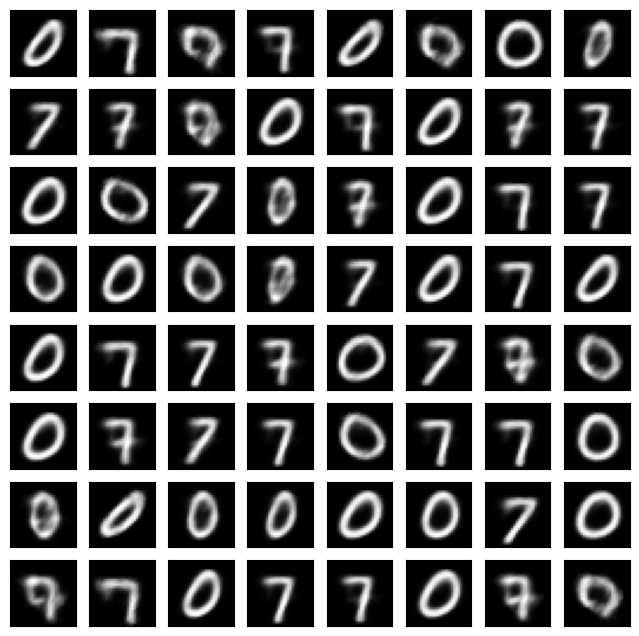

In [33]:
samples = sample_from_vae(model = model_1x, num_samples=64, z_dim=Z_DIM, device=device)
# Plot the generated samples in an 8x8 grid
plt.figure(figsize=(8, 8))  # Adjusted for larger display

for i in range(8):  # Rows
    for j in range(8):  # Columns
        idx = i * 8 + j
        ax = plt.subplot(8, 8, idx + 1)
        plt.imshow(samples[idx], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

In [34]:
import matplotlib.pyplot as plt
import numpy as np  # Importing numpy, as it was used in the previous code but not imported

# Extract embeddings and labels
embeddings, labels = [], []

# Assuming model1 is your trained VAE and train_loader is your DataLoader
for x, y in train_loader:
    x = x.to(device).view(x.shape[0], INPUT_DIM)
    mu, _ = model_1x.encode(x)
    embeddings.append(mu.detach().cpu().numpy())
    labels.append(y.detach().cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

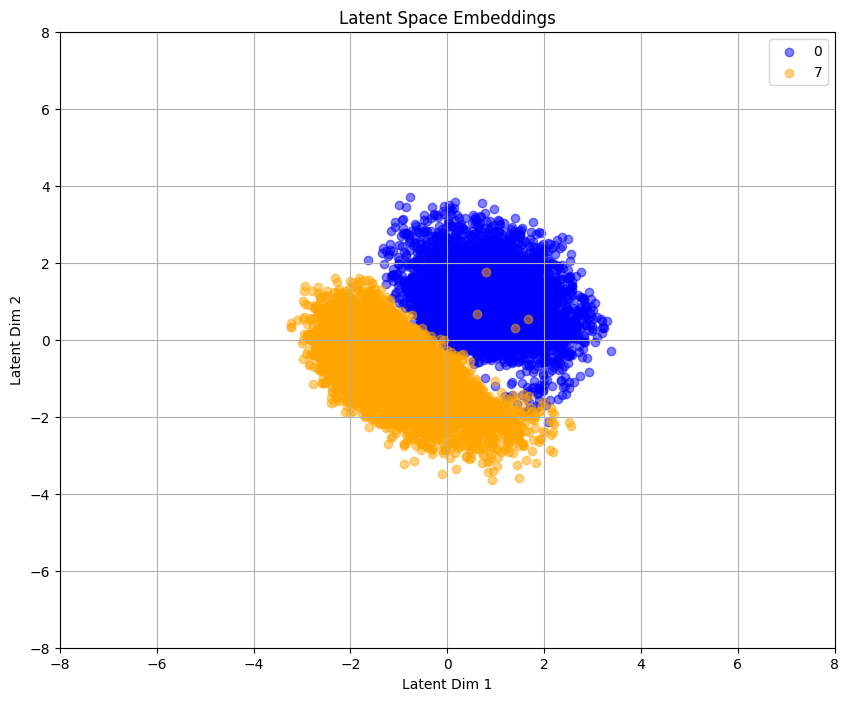

In [35]:
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(embeddings[labels==0, 0], embeddings[labels==0, 1], alpha=0.5, label='0', color='blue')
plt.scatter(embeddings[labels==7, 0], embeddings[labels==7, 1], alpha=0.5, label='7', color='orange')
plt.legend()
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Latent Space Embeddings')
plt.grid(True)


plt.xlim(-8, 8)
plt.ylim(-8, 8)
    
plt.show()

## 4. Find the decision boundary of an ordinary VAE

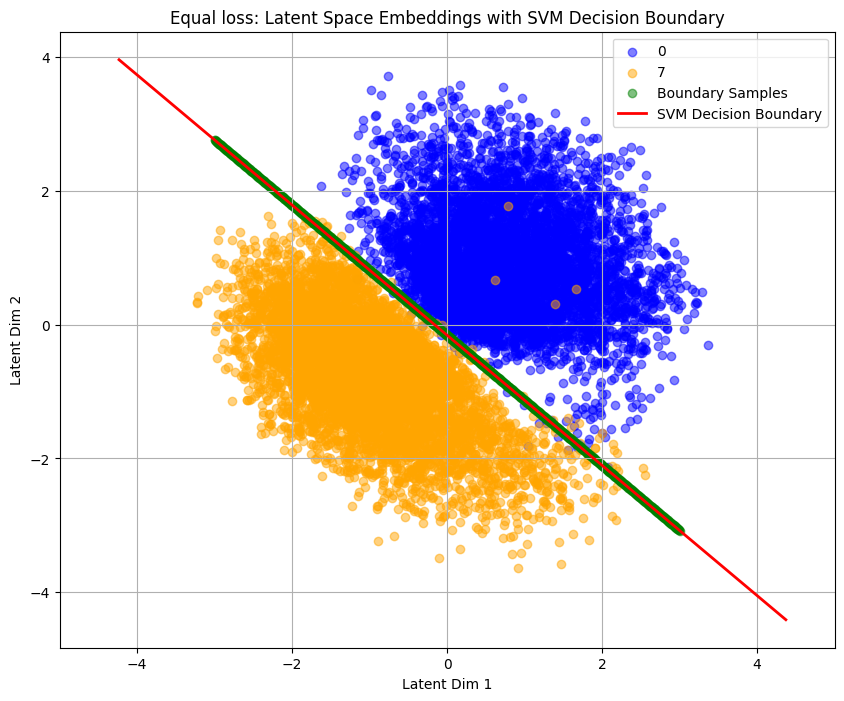

In [38]:
from sklearn.svm import SVC

# Extract the embeddings for digits 0 and 7 only
zero_embeddings = embeddings[labels == 0]
seven_embeddings = embeddings[labels == 7]
combined_embeddings = np.vstack((zero_embeddings, seven_embeddings))
combined_labels = np.hstack((np.zeros(zero_embeddings.shape[0]), np.ones(seven_embeddings.shape[0])))

# Fit an SVM model to the combined embeddings
svm = SVC(kernel='linear')
svm.fit(combined_embeddings, combined_labels)

# Get the weights and intercept of the hyperplane
w = svm.coef_[0]
i = svm.intercept_

# The hyperplane is given by w[0]*x + w[1]*y + i = 0
# Solve for y to get the equation of the line: y = -(w[0]/w[1])*x - (i/w[1])
slope = -w[0] / w[1]
intercept = -i / w[1]

# Create a range of x values for plotting the decision boundary line
x_min, x_max = embeddings[:, 0].min() - 1, embeddings[:, 0].max() + 1
x_values = np.linspace(x_min, x_max, num=1000)
# Calculate the corresponding y values using the slope and intercept
y_values = slope * x_values + intercept
x_min, x_max = embeddings[:, 0].min() - 1, embeddings[:, 0].max() + 1

#BOUNDARY SAMPLES
# Create a range of x values for plotting the decision boundary line
x_min, x_max = -3, 3
sample_x_values = np.linspace(x_min, x_max, num=1000)
sample_y_values = slope * sample_x_values + intercept
# Generate samples along the decision boundary
boundary_samples = np.vstack((sample_x_values, sample_y_values)).T

# Define the range you want for the x-axis
x_min_expanded = -5  # for example, -5 instead of -3
x_max_expanded = 5   # for example, 5 instead of 3

# Plot the embeddings and the decision boundary
plt.figure(figsize=(10, 8))
plt.scatter(zero_embeddings[:, 0], zero_embeddings[:, 1], alpha=0.5, label='0', color='blue')
plt.scatter(seven_embeddings[:, 0], seven_embeddings[:, 1], alpha=0.5, label='7', color='orange')
plt.scatter(boundary_samples[:, 0], boundary_samples[:, 1], alpha=0.5, label='Boundary Samples', color='green')
plt.plot(x_values, y_values, color='red', linewidth=2, label='SVM Decision Boundary')
plt.legend()
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Equal loss: Latent Space Embeddings with SVM Decision Boundary')
plt.grid(True)
plt.xlim(x_min_expanded, x_max_expanded)
# Save the plot
plt.savefig('plots/svm_decision_boundary_plot.png', format='png')
plt.show()

## 5. Use points on the decision boundary to generate 1,000 samples (decode)

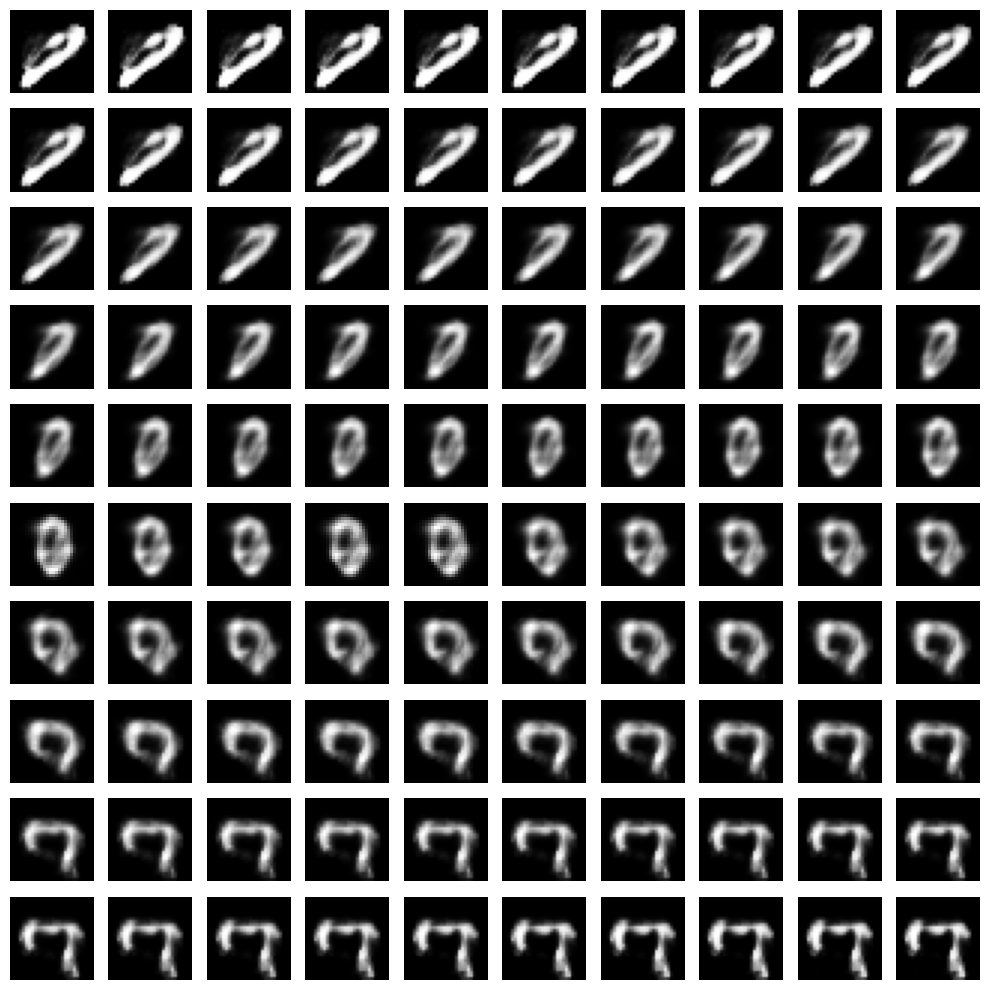

In [40]:
# Convert boundary samples to a PyTorch tensor
boundary_samples_tensor = torch.tensor(boundary_samples, dtype=torch.float32).to(device)

# Decode the boundary samples using the trained VAE model
with torch.no_grad():  # No need to compute gradients when generating images
    decoded_images = model_1x.decode(boundary_samples_tensor)

# Reshape the output images to 28x28 (assuming MNIST images)
decoded_images_reshaped = decoded_images.view(-1, 28, 28).cpu().numpy()

# Assuming decoded_images_reshaped contains the 1000 decoded images
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    # Display every 10th image
    index = i * 10
    if index < len(decoded_images_reshaped):
        ax.imshow(decoded_images_reshaped[index], cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.savefig('plots/decision_boundary_digits.png', format='png')
plt.show()

In [42]:
print(decoded_images.shape)

torch.Size([1000, 784])


## 6. Train 4 VAE models on asymmetric loss: 10x, 50x, 100x, 1000x

In [43]:
digit_proportions = {0: 0.5, 7: 0.5}
#penalty in the training, compared to non penalized
penalized_list = [0]
non_penalized_list = [7]
penalized_factor = [10,50,100]


model_10x = VariationalAutoEncoder(input_dim = INPUT_DIM, hidden_dim = H_DIM, z_dim = Z_DIM).to(device)
train_vae_with_penalty(model=model_10x, 
                       train_loader=train_loader, device=device,
                       input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
                       lr_rate=LR_RATE, 
                       penalized_factor=penalized_factor[0],
                       penalized_list=penalized_list)


model_50x = VariationalAutoEncoder(input_dim = INPUT_DIM, hidden_dim = H_DIM, z_dim = Z_DIM).to(device)
train_vae_with_penalty(model=model_50x, 
                       train_loader=train_loader, device=device,
                       input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
                       lr_rate=LR_RATE, 
                       penalized_factor=penalized_factor[1],
                       penalized_list=penalized_list)



model_100x = VariationalAutoEncoder(input_dim = INPUT_DIM, hidden_dim = H_DIM, z_dim = Z_DIM).to(device)
train_vae_with_penalty(model=model_100x, 
                       train_loader=train_loader, device=device,
                       input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
                       lr_rate=LR_RATE, 
                       penalized_factor=penalized_factor[2],
                       penalized_list=penalized_list)

model_1000x = VariationalAutoEncoder(input_dim = INPUT_DIM, hidden_dim = H_DIM, z_dim = Z_DIM).to(device)
train_vae_with_penalty(model=model_1000x, 
                       train_loader=train_loader, device=device,
                       input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
                       lr_rate=LR_RATE, 
                       penalized_factor=1000,
                       penalized_list=penalized_list)

In [ ]:
# model_1x_test = VariationalAutoEncoder(input_dim = INPUT_DIM, hidden_dim = H_DIM, z_dim = Z_DIM).to(device)
# train_vae_with_penalty(model=model_1x_test, 
#                        train_loader=train_loader, device=device,
#                        input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
#                        lr_rate=LR_RATE, 
#                        penalized_factor=1,
#                        penalized_list=penalized_list)

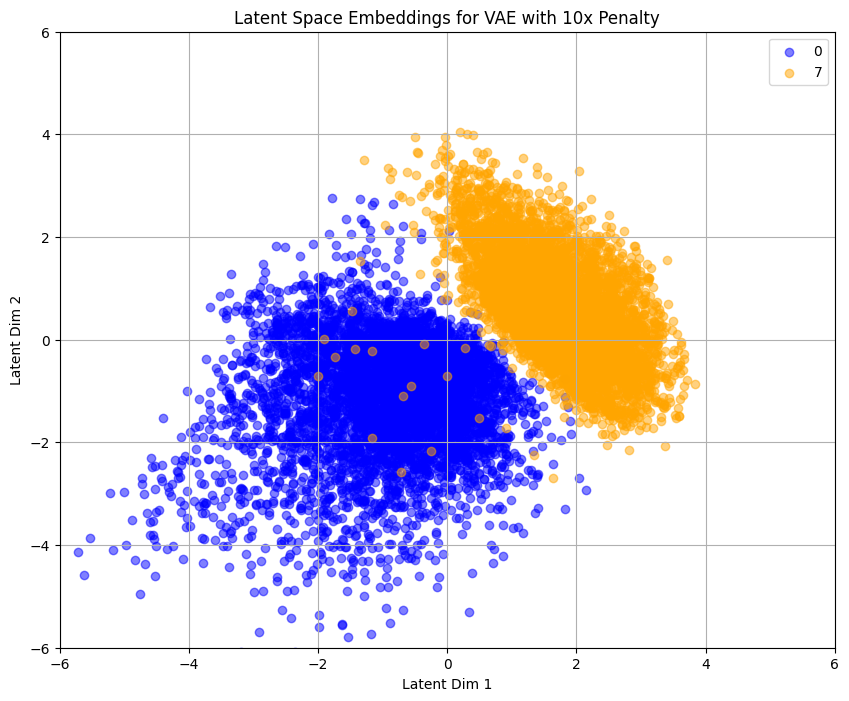

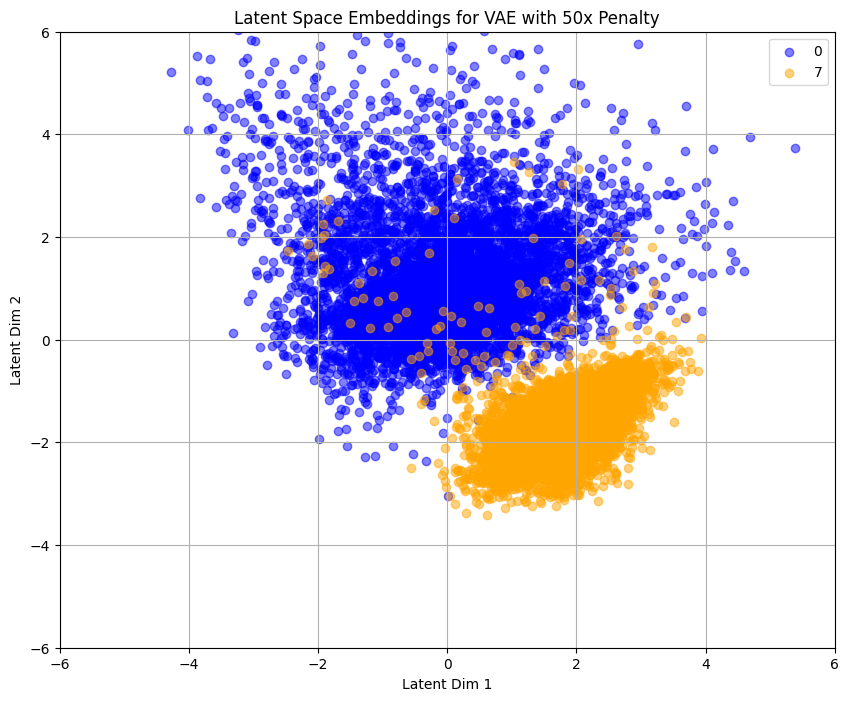

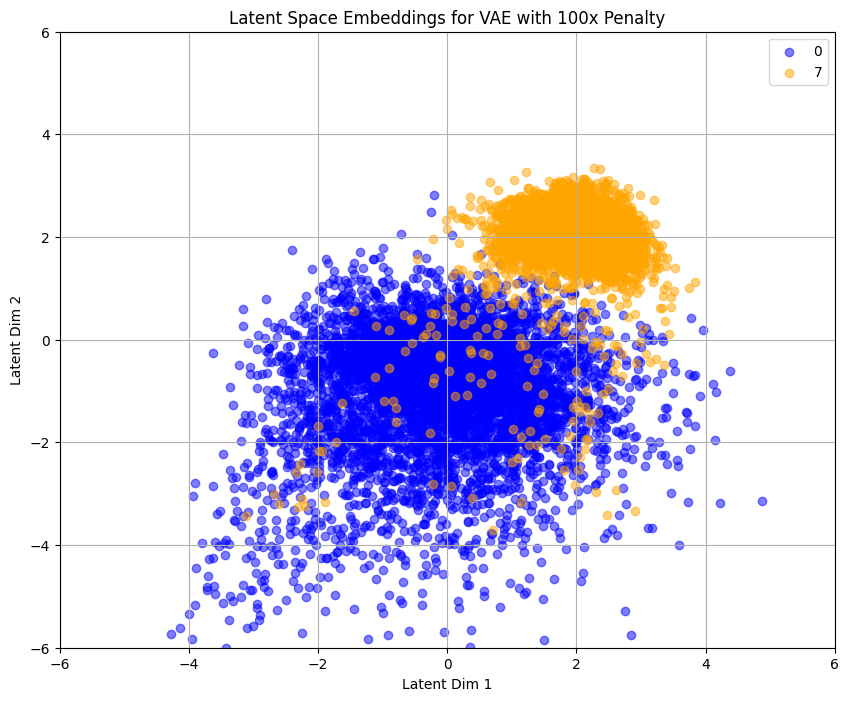

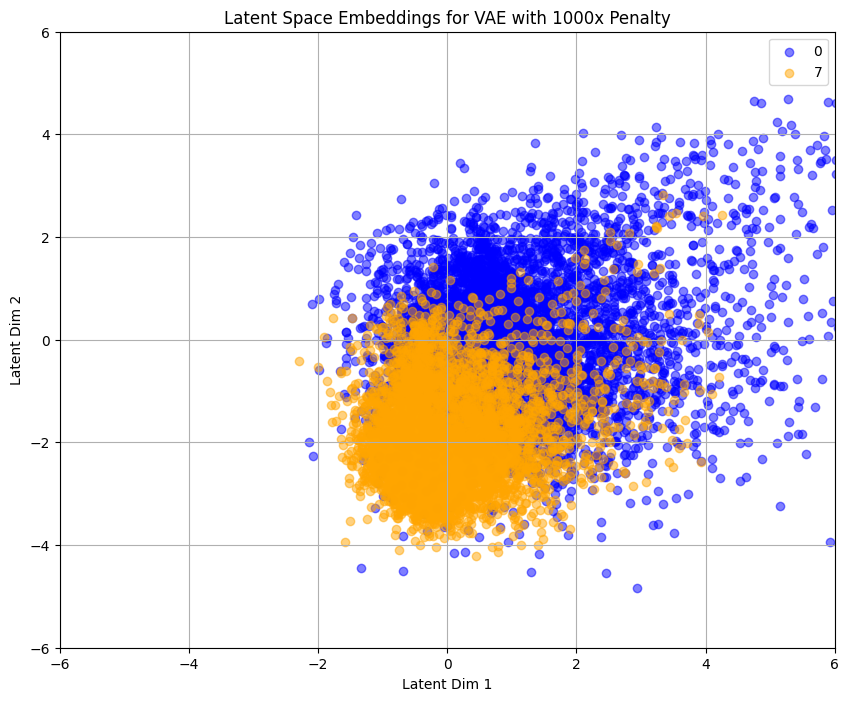

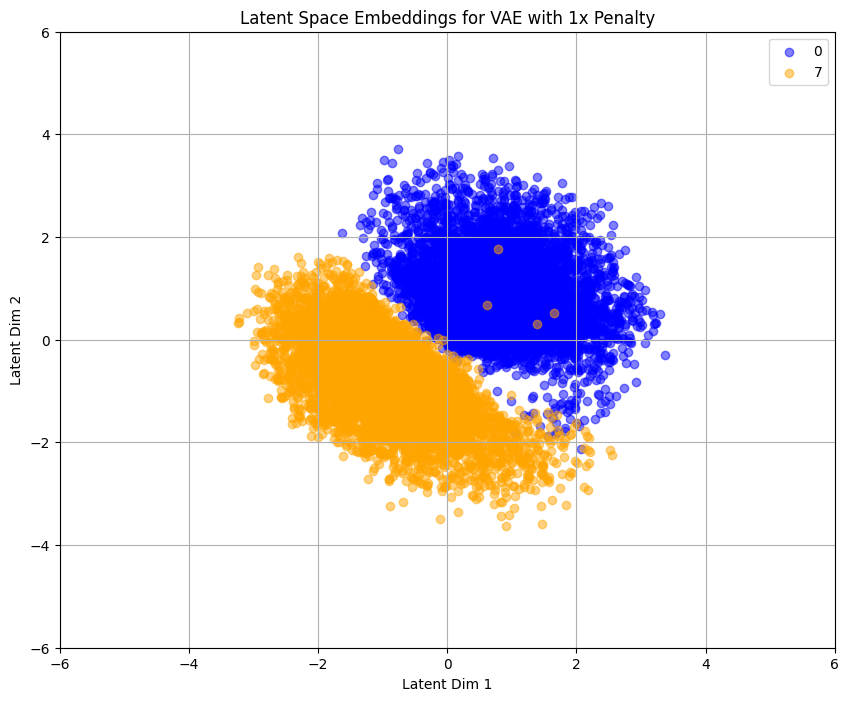

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latent_space_embeddings(model, train_loader, device, input_dim, title):
    # Extract embeddings and labels
    embeddings, labels = [], []

    for x, y in train_loader:
        x = x.to(device).view(x.shape[0], input_dim)
        mu, _ = model.encode(x)
        embeddings.append(mu.detach().cpu().numpy())
        labels.append(y.detach().cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[labels==0, 0], embeddings[labels==0, 1], alpha=0.5, label='0', color='blue')
    plt.scatter(embeddings[labels==7, 0], embeddings[labels==7, 1], alpha=0.5, label='7', color='orange')
    plt.legend()
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.title(title)
    plt.grid(True)

    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    
    plt.show()

# Plot for each VAE model
plot_latent_space_embeddings(model_10x, train_loader, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 10x Penalty')
plot_latent_space_embeddings(model_50x, train_loader, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 50x Penalty')
plot_latent_space_embeddings(model_100x, train_loader, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 100x Penalty')
plot_latent_space_embeddings(model_1000x, train_loader, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 1000x Penalty')
plot_latent_space_embeddings(model_1x, train_loader, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 1x Penalty')

## 7. Feed the 1000 decision-boundary points from the latent space of the ordinary VAE to the 3 asymmetric VAEs and see where they are located

In [47]:
print(decoded_images.shape)

torch.Size([1000, 784])


In [48]:
def encode_images(model, images, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Ensure images are a tensor and moved to the correct device
        if not isinstance(images, torch.Tensor):
            images = torch.tensor(images, dtype=torch.float32).to(device)
        else:
            images = images.to(device)
        
        # Encode images
        mu, _ = model.encode(images)
        return mu.detach().cpu().numpy()

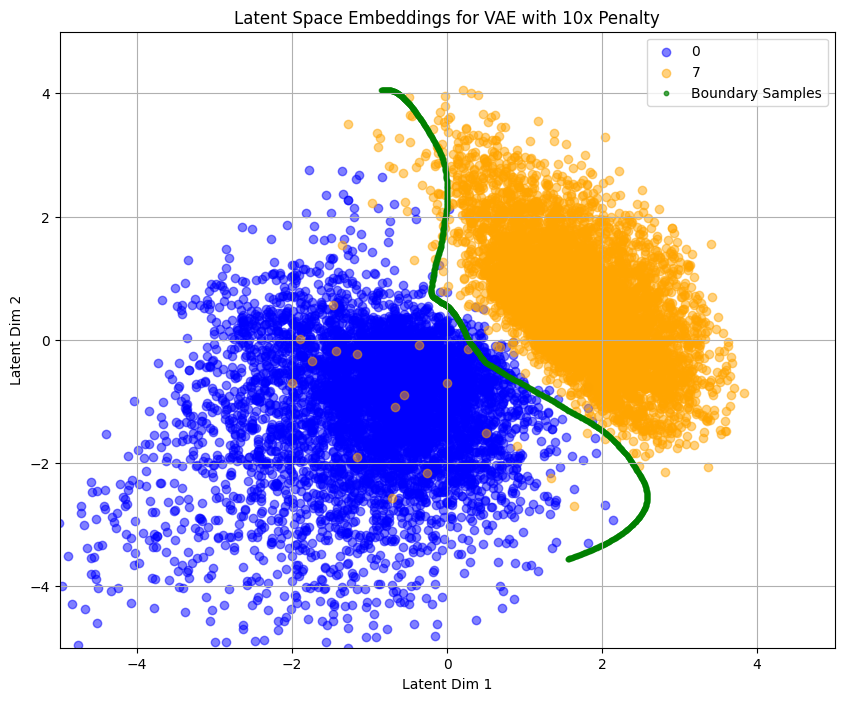

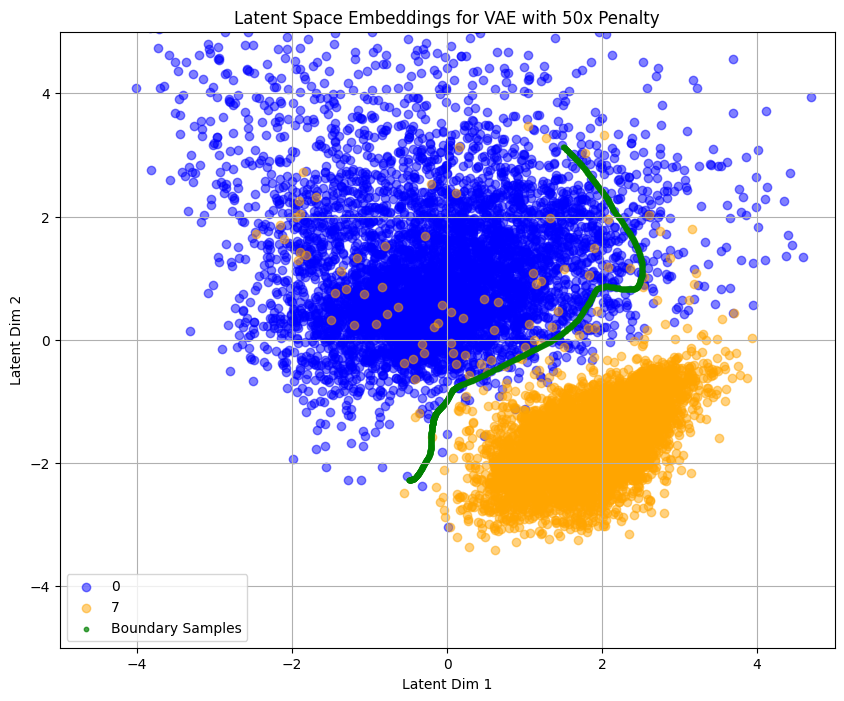

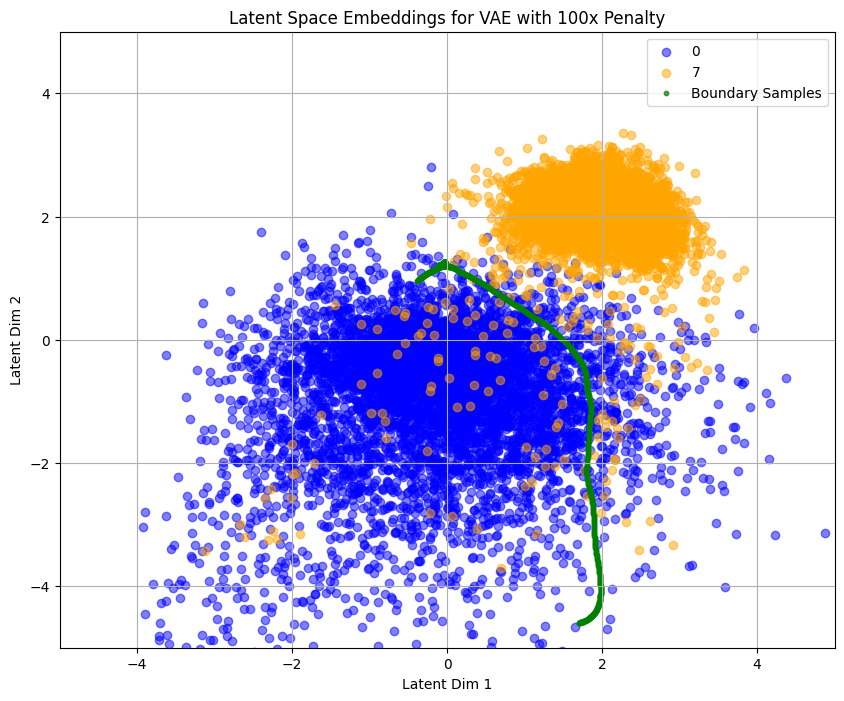

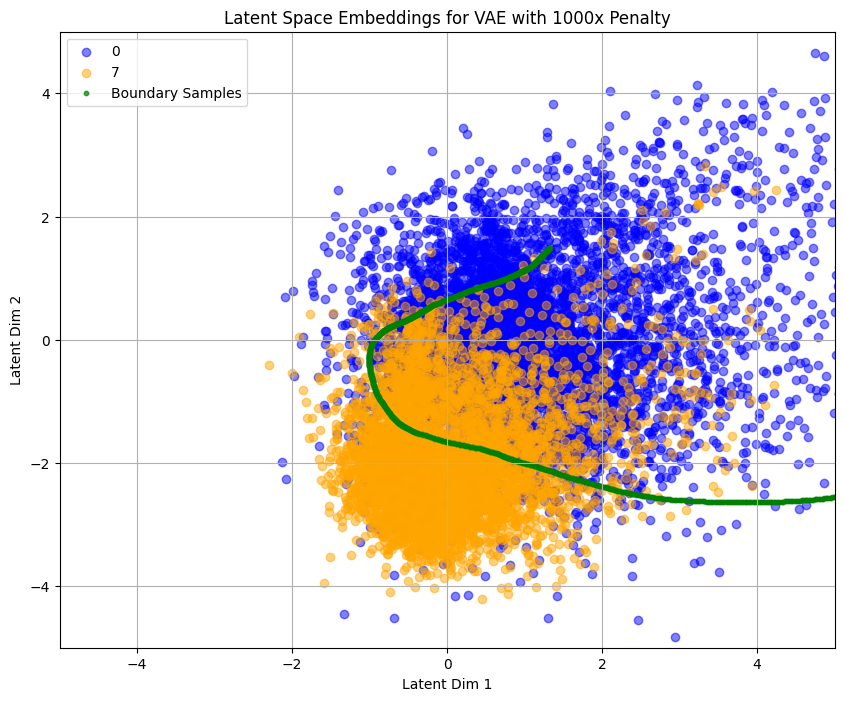

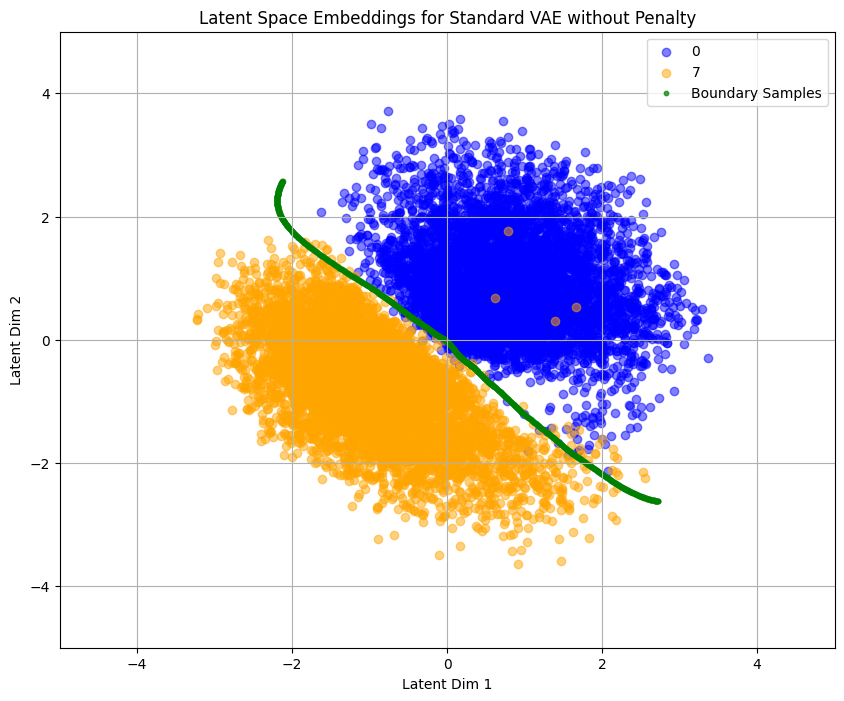

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latent_space_embeddings(model, train_loader, additional_embeddings, device, input_dim, title, graph_title):
    # Extract embeddings and labels
    embeddings, labels = [], []

    for x, y in train_loader:
        x = x.to(device).view(x.shape[0], input_dim)
        mu, _ = model.encode(x)
        embeddings.append(mu.detach().cpu().numpy())
        labels.append(y.detach().cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[labels==0, 0], embeddings[labels==0, 1], alpha=0.5, label='0', color='blue')
    plt.scatter(embeddings[labels==7, 0], embeddings[labels==7, 1], alpha=0.5, label='7', color='orange')
    # Plot additional embeddings on the same graph
    plt.scatter(additional_embeddings[:, 0], additional_embeddings[:, 1], alpha=0.7, label='Boundary Samples', color='green', s=10)
    plt.legend()
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.title(title)
    plt.grid(True)

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.savefig('plots/' + graph_title + '.png', dpi=300, bbox_inches='tight')  # Adjust the filename and dpi as needed
    
    plt.show()

# Encode the decoded images using each VAE and then plot the embeddings
boundary_embeddings_10x = encode_images(model_10x, decoded_images, device)
boundary_embeddings_50x = encode_images(model_50x, decoded_images, device)
boundary_embeddings_100x = encode_images(model_100x, decoded_images, device)
boundary_embeddings_1000x = encode_images(model_1000x, decoded_images, device)
boundary_embeddings_1x = encode_images(model_1x, decoded_images, device)

# Plot for each VAE model
plot_latent_space_embeddings(model_10x, train_loader, boundary_embeddings_10x, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 10x Penalty', graph_title = "10x")
plot_latent_space_embeddings(model_50x, train_loader, boundary_embeddings_50x, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 50x Penalty', graph_title = "50x")
plot_latent_space_embeddings(model_100x, train_loader, boundary_embeddings_100x, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 100x Penalty', graph_title = "100x")
plot_latent_space_embeddings(model_1000x, train_loader, boundary_embeddings_1000x, device, INPUT_DIM, 'Latent Space Embeddings for VAE with 1000x Penalty', graph_title = "1000x")
plot_latent_space_embeddings(model_1x, train_loader, boundary_embeddings_1x, device, INPUT_DIM, 'Latent Space Embeddings for Standard VAE without Penalty', graph_title = "1x")